<a href="https://colab.research.google.com/github/RomainGratier/Black-box_Optimization_via_Deep_Generative-Exploratory_Networks/blob/master/CGANtest_thickness_continuous_mnist_FID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# SEED EVERYTHING
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd 
import random

import os 
from copy import deepcopy
import shutil

import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2

# Set up the main variables

In [2]:
n_epochs = 125
batch_size = 128
lr=0.0002
b1=0.5
b2=0.999
n_cpu=8
latent_dim=100
label_dim_input=1 #14
img_size=28
channels=1
sample_interval=1000
n_row = 10

img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

# Create the classes for the models and the dataset

In [3]:
import os
os.chdir('/Users/4romain/pCloud Drive/ml_master_thesis/repo/')
import sys
sys.path.append("Black-box_Optimization_via_Deep_Generative-Exploratory_Networks/")
from src.generative_model import Generator, Discriminator
from src.data import MNISTDataset
from src.generative_model import sample_image, save_model_check

### Create the dataset

 ---------------------------------------- CHECK NANS
Empty DataFrame
Columns: [index, area, length, thickness, slant, width, height, digit]
Index: []
              index          area        length     thickness         slant  \
count  54251.000000  54251.000000  54251.000000  54251.000000  54251.000000   
mean   30149.049160     97.446472     37.843823      2.669598      0.099922   
std    17335.099438     61.981228     11.781744      1.343455      0.256971   
min        0.000000      4.875000      3.517767      0.713251     -0.966770   
25%    15185.500000     44.375000     29.531223      1.463335     -0.075722   
50%    30258.000000     85.812500     38.377417      2.374688      0.099015   
75%    45199.500000    138.000000     46.284271      3.557524      0.283160   
max    59999.000000    347.000000     80.661688      5.999532      1.030909   

              width        height         digit  
count  54251.000000  54251.000000  54251.000000  
mean      12.805878     18.977384     

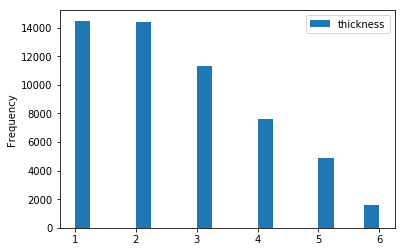

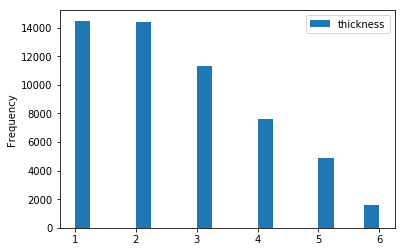

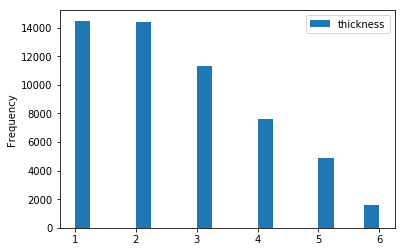

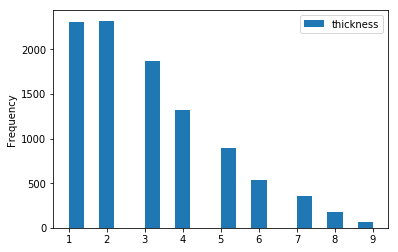

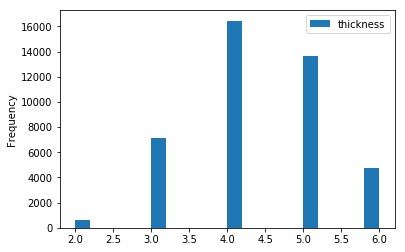

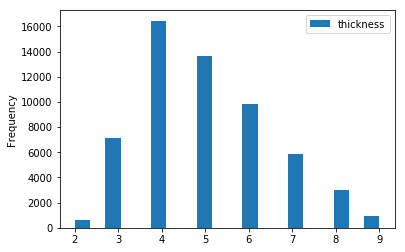

In [4]:
## GAN
dataset = MNISTDataset('train', 'thickness', data_type='morpho_mnist/global')

dataloader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

# Forward
trainset = MNISTDataset('train', 'thickness', data_type='morpho_mnist/global')
trainloader = DataLoader(dataset=trainset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

testset = MNISTDataset('test', 'thickness', data_type='morpho_mnist/global')
testloader = DataLoader(dataset=testset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

# Inference
fulldataset = MNISTDataset('full', 'thickness', data_type='morpho_mnist/thic')

### Define the main parameters to train the Generative Adversarial Network

In [5]:
#path_generator = 'drive/My Drive/master_thesis/models_mid/generative_wo_weight_global/'

def load_obj_csv(path):
    return pd.read_csv(path+'.csv')

def save_obj_csv(d, path):
    d.to_csv(path+'.csv', index=False)

def train_loop():

    mse_gan_in_distribution = []
    mse_gan_out_distribution = []
    df_acc_gen = pd.DataFrame(columns=['mse_in', 'mse_out', 'fid_in', 'fid_out'])

    '''if os.path.exists(path_generator):
        df_check_in_distribution = load_obj_csv(os.path.join(path_generator, 'results_in_distribution'))
        df_check_out_distribution = load_obj_csv(os.path.join(path_generator, 'results_out_distribution'))
    else:
        os.makedirs(path_generator)
        df_check_in_distribution = None
        df_check_out_distribution = None'''

    df_check_in_distribution = None
    df_check_out_distribution = None
    
    # Loss functions
    adversarial_loss = torch.nn.MSELoss()

    # Initialize generator and discriminator
    generator = Generator()
    discriminator = Discriminator()


    if cuda:
        generator.cuda()
        discriminator.cuda()
        adversarial_loss.cuda()

    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

    FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
    LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

    if os.path.isdir("images"):
        shutil.rmtree("images")
    os.makedirs("images", exist_ok=True)

    # FID needs
    df_test_in = pd.DataFrame(dataset.labels.values, columns=['label'])
    df_test_out = pd.DataFrame(fulldataset.labels.values, columns=['label'])
    index_in_distribution = df_test_in[df_test_in['label']<=dataset.maximum_label].index
    index_out_distribution = df_test_out[df_test_out['label']>dataset.maximum_label].index
    print(f'size of in distribution data for fid/kid : {len(index_in_distribution)}')
    print(f'size of out distribution data for fid/kid : {len(index_out_distribution)}')
    real_dataset_in = deepcopy(dataset.x_data)
    real_dataset_out = deepcopy(fulldataset.x_data)

    arr = np.array([num for num in np.arange(0, 1, 1/n_row)])
    print(f"Checkup the plots of the displayed labels {arr}")
    in_distribution_index = np.where(arr <= dataset.maximum)
    out_distribution_index = np.where(arr > dataset.maximum)

    best_res_in = 100000
    best_res_out = 100000

    for epoch in range(n_epochs):
        d_loss_check = []
        g_loss_check = []

        if (epoch+1) % 50 == 0:
            optimizer_G.param_groups[0]['lr'] /= 10
            optimizer_D.param_groups[0]['lr'] /= 10
            print("learning rate change!")

        for i, (imgs, labels) in enumerate(dataloader):
            ## Initialization
            batch_size = imgs.shape[0]

            # Adversarial ground truths
            valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
            fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(imgs.type(FloatTensor))
            labels = Variable(labels.type(FloatTensor))

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Sample noise and labels as generator input
            z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
            gen_labels = Variable(FloatTensor(np.random.rand(batch_size))) 

            # Generate a batch of images
            gen_imgs = generator(z, gen_labels)

            # Loss measures generator's ability to fool the discriminator
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, valid)

            g_loss.backward()
            optimizer_G.step()

            g_loss_check.append(g_loss.item())

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Loss for real images
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)

            # Loss for fake images
            validity_fake = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            d_loss_check.append(d_loss.item())

            batches_done = epoch * len(dataloader) + i
            if batches_done % sample_interval == 0:

                print(
                  "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                  % (epoch, n_epochs, i, len(dataloader), np.mean(d_loss_check), np.mean(g_loss_check))
                )

                # Delete useless data from GPU
                del valid; del fake; del real_imgs; del labels; del z; del gen_labels; del g_loss; del d_loss; del gen_imgs; del validity;
                torch.cuda.empty_cache()

                mse_gan, fid_in, kid_in, fid_out, kid_out = sample_image(n_row, batches_done, in_distribution_index, out_distribution_index, real_dataset_in, real_dataset_out, index_in_distribution, index_out_distribution, generator, dataset, 1000)

                mean_in_mse = np.mean(mse_gan[in_distribution_index])
                mean_out_mse = np.mean(mse_gan[out_distribution_index])

                mse_gan_in_distribution.append(mse_gan[in_distribution_index])
                mse_gan_out_distribution.append(mse_gan[out_distribution_index])

                df = pd.DataFrame([mean_in_mse], columns=['mse_in'])
                df['mse_out'] = mean_out_mse
                df['fid_in'] = fid_in[0]
                df['fid_out'] = fid_out[0]
                df['kid_in'] = kid_in[0]
                df['kid_out'] = kid_out[0]

                df_acc_gen = df_acc_gen.append(df, ignore_index=True)

                '''# Check if we have better results
                df_check_in_distribution, best_res_in = save_model_check('in', df_check_in_distribution, df['mse_in'].values, best_res_in, df_acc_gen, path_generator, generator)
                df_check_out_distribution, best_res_out = save_model_check('out', df_check_out_distribution, df['mse_out'].values, best_res_out, df_acc_gen, path_generator, generator)
'''
    return mse_gan_in_distribution, mse_gan_out_distribution, df_acc_gen

!nvidia-smi

/bin/sh: nvidia-smi: command not found


### Training loop GAN




In [6]:
mse_gan_in_distribution, mse_gan_out_distribution, df_acc_gen = train_loop()

size of in distribution data for fid/kid : 54251
size of out distribution data for fid/kid : 14901
Checkup the plots of the displayed labels [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[Epoch 0/125] [Batch 0/424] [D loss: 0.527005] [G loss: 1.034517]


100%|##########| 100/100 [00:06<00:00, 16.07img/s]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.9200987 0.9938154


FID: 100%|██████████| 10/10 [00:00<00:00, 40.07it/s, mean=121]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.9200987 0.9938154
MMD: 100%|██████████| 100/100 [00:00<00:00, 418.25it/s, mean=4.07]
(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(1000, 1, 32, 32) 0.9198133 0.9936454


FID: 100%|██████████| 10/10 [00:00<00:00, 50.63it/s, mean=83.2]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(1000, 1, 32, 32) 0.9198133 0.9936454
MMD: 100%|██████████| 100/100 [00:00<00:00, 394.16it/s, mean=2.9]

The thickness distribution =
[0.16600933 0.1653905  0.16871361 0.16863863 0.1693025  0.16154997
 0.16784451 0.16592592 0.1645785  0.16750066]
Average MSE In dist = 4.578482359646903 \ Average MSE Out dist = 24.963837307918155

FID score in distribution : mean = 120.8988 \ std = 0.6566
FID score out distribution : mean = 83.21 \ std = 0.9658

KID score in distribution : mean = 4.0693 \ std = 0.1493
KID score out distribution : mean = 2.901 \ std = 0.1076


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[Epoch 2/125] [Batch 152/424] [D loss: 0.062249] [G loss: 0.791338]


100%|##########| 100/100 [00:06<00:00, 15.69img/s]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 1.5355648e-05 0.9999981


FID: 100%|██████████| 10/10 [00:00<00:00, 45.58it/s, mean=53.5]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 1.5355648e-05 0.9999981
MMD: 100%|██████████| 100/100 [00:00<00:00, 380.91it/s, mean=0.737]
(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(1000, 1, 32, 32) 1.7009676e-05 0.99999666


FID: 100%|██████████| 10/10 [00:00<00:00, 43.84it/s, mean=46.4]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(1000, 1, 32, 32) 1.7009676e-05 0.99999666
MMD: 100%|██████████| 100/100 [00:00<00:00, 365.34it/s, mean=0.58]

The thickness distribution =
[0.11118043 0.08382329 0.08507812 0.07390966 0.07676105 0.10146509
 0.10848511 0.09469645 0.09559691 0.07257173]
Average MSE In dist = 6.293549287013731 \ Average MSE Out dist = 31.348862169309452

FID score in distribution : mean = 53.5363 \ std = 0.8347
FID score out distribution : mean = 46.3921 \ std = 0.7546

KID score in distribution : mean = 0.7375 \ std = 0.0857
KID score out distribution : mean = 0.5795 \ std = 0.0747


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[Epoch 4/125] [Batch 304/424] [D loss: 0.044481] [G loss: 0.868164]


100%|##########| 100/100 [00:06<00:00, 16.01img/s]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 45.77it/s, mean=52.8]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.0 1.0
MMD: 100%|██████████| 100/100 [00:00<00:00, 373.54it/s, mean=0.848]
(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(1000, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 44.39it/s, mean=50.6]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(1000, 1, 32, 32) 0.0 1.0
MMD: 100%|██████████| 100/100 [00:00<00:00, 385.90it/s, mean=0.763]

The thickness distribution =
[0.11257375 0.14796237 0.14835009 0.10942074 0.16153173 0.14871987
 0.14738851 0.15252862 0.16799769 0.15147923]
Average MSE In dist = 4.903536467799115 \ Average MSE Out dist = 25.478729365682646

FID score in distribution : mean = 52.7673 \ std = 0.713
FID score out distribution : mean = 50.6085 \ std = 0.5235

KID score in distribution : mean = 0.8478 \ std = 0.0881
KID score out distribution : mean = 0.7632 \ std = 0.0904


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[Epoch 7/125] [Batch 32/424] [D loss: 0.064057] [G loss: 0.830056]


100%|##########| 100/100 [00:06<00:00, 14.80img/s]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 50.03it/s, mean=32.3]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.0 1.0
MMD: 100%|██████████| 100/100 [00:00<00:00, 387.46it/s, mean=0.438]
(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(1000, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 43.13it/s, mean=43.5]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(1000, 1, 32, 32) 0.0 1.0
MMD: 100%|██████████| 100/100 [00:00<00:00, 373.08it/s, mean=0.911]

The thickness distribution =
[0.17400042 0.13250596 0.14769717 0.20546778 0.1923602  0.18468014
 0.14788295 0.20814791 0.17197014 0.14100452]
Average MSE In dist = 4.193803303605883 \ Average MSE Out dist = 25.76506346033929

FID score in distribution : mean = 32.297 \ std = 0.6899
FID score out distribution : mean = 43.5386 \ std = 0.9474

KID score in distribution : mean = 0.4375 \ std = 0.0638
KID score out distribution : mean = 0.9114 \ std = 0.0973


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[Epoch 9/125] [Batch 184/424] [D loss: 0.072929] [G loss: 0.782876]


100%|##########| 100/100 [00:06<00:00, 14.65img/s]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 49.13it/s, mean=22.8]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.0 1.0
MMD: 100%|██████████| 100/100 [00:00<00:00, 282.27it/s, mean=0.407]
(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(1000, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 42.11it/s, mean=26.8]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(1000, 1, 32, 32) 0.0 1.0
MMD: 100%|██████████| 100/100 [00:00<00:00, 341.36it/s, mean=0.598]

The thickness distribution =
[0.16065742 0.16285195 0.18716486 0.22329756 0.16342917 0.17836126
 0.13916853 0.22989407 0.20471153 0.19473402]
Average MSE In dist = 4.172018560502229 \ Average MSE Out dist = 22.61305216859112

FID score in distribution : mean = 22.7901 \ std = 0.7135
FID score out distribution : mean = 26.8065 \ std = 1.448

KID score in distribution : mean = 0.4069 \ std = 0.1014
KID score out distribution : mean = 0.5982 \ std = 0.1009


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[Epoch 11/125] [Batch 336/424] [D loss: 0.080220] [G loss: 0.755835]


100%|##########| 100/100 [00:06<00:00, 14.57img/s]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 49.36it/s, mean=23]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.0 1.0
MMD: 100%|██████████| 100/100 [00:00<00:00, 379.17it/s, mean=0.531]
(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(1000, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 41.00it/s, mean=25.8]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(1000, 1, 32, 32) 0.0 1.0
MMD: 100%|██████████| 100/100 [00:00<00:00, 333.24it/s, mean=0.744]

The thickness distribution =
[0.14752472 0.15677466 0.24367527 0.23309913 0.21503028 0.3153564
 0.31199692 0.40918356 0.3309706  0.34533031]
Average MSE In dist = 1.7734115070226364 \ Average MSE Out dist = 14.00816126206825

FID score in distribution : mean = 22.9983 \ std = 1.0863
FID score out distribution : mean = 25.8057 \ std = 0.9938

KID score in distribution : mean = 0.5313 \ std = 0.1008
KID score out distribution : mean = 0.7444 \ std = 0.1319


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


KeyboardInterrupt: 

### Comments :
We can see that in distribution the model continue after multiple epochs to converge. But the out of distribution generated data in early epochs start to collapse in modes ! The FID score is decreasing for the distribution present in the training set but not for the out of distribution at a certain point

### Save/Load the model

In [ ]:
# Then later:
best_generator_in_distribution = torch.load(os.path.join(path_generator, 'best_generator_in_distribution.pth'))
best_generator_out_distribution = torch.load(os.path.join(path_generator, 'best_generator_out_distribution.pth'))
best_generator_in_distribution.eval()
best_generator_out_distribution.eval()

Generator(
  (label_emb): Embedding(1, 1)
  (model): Sequential(
    (0): Linear(in_features=101, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [ ]:
data_in = np.mean(mse_gan_in_distribution,axis=1)
data_out = np.mean(mse_gan_out_distribution,axis=1)

# libraries and data
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(color_codes=True)
df=pd.DataFrame({'x': [i * sample_interval * batch_size for i in range(0,len(data_in))], 'y': data_in, 'z': data_out})

# fist line:
plt.subplots(figsize=(10,5), dpi=100)
ax = sns.regplot(x="x", y="y", data=df, label = 'In distribution',
                 scatter_kws={"s": 80},
                 order=3, ci=None)
ax = sns.regplot(x="x", y="z", data=df, label = 'Out distribution',
                 scatter_kws={"s": 80},
                 order=2, ci=None)

plt.ylabel('Mean Squared Error')
plt.xlabel('iterations')
plt.legend()
plt.title("Accuracy without reweighting strategy")

# Forward model

In [ ]:
#from src.models import train_forward_model
from src.models import ForwardModel
forward = ForwardModel()

def eval_forward(dist, df_check, mean_out, best_res, df_acc_gen, path_forward, model):
    if df_check is not None:
        if mean_out < df_check[f'mse_{dist}'].iloc[-1]:
            print(f" ---------- Better Results {dist} distribution of : {df_check[f'mse_{dist}'].iloc[-1] - mean_out} ---------- ")
            torch.save(model, os.path.join(path_forward, f"best_forward_{dist}_distribution.pth"))
            save_obj_csv(df_acc_gen, os.path.join(path_forward, f"results_{dist}_distribution"))

            best_res = mean_out
            df_check = None

    else:
        if mean_out < best_res:
            print(f" ---------- Model Improving {dist} distribution of : {best_res - mean_out}---------- ")
            torch.save(model, os.path.join(path_forward, f"best_forward_{dist}_distribution.pth"))
            save_obj_csv(df_acc_gen, os.path.join(path_forward, f"results_{dist}_distribution"))

            best_res = mean_out

    return df_check, best_res

def train_forward_model():
    import multiprocessing
    from src.metrics import mse
    from src.models import ForwardModel, RMSELoss
    from morphomnist.measure import measure_batch

    forward = ForwardModel()
    optimizer_F = torch.optim.Adam(forward.parameters(), lr=0.00001, betas=(0.1, 0.3))
    forward_loss = RMSELoss() #nn.MSELoss()

    path_forward = '/content/drive/My Drive/master_thesis/models/forward/'
    if os.path.exists(path_forward):
        df_check = load_obj_csv(os.path.join(path_forward, 'results'))
    else:
        os.makedirs(path_forward)
        df_check = None

    FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
    DoubleTensor = torch.cuda.DoubleTensor if cuda else torch.DoubleTensor

    if cuda:
        forward.cuda()
        forward_loss.cuda()

    n_ep = 20
    best_res = 10000
    df_acc_final = pd.DataFrame(columns=['label_norm', 'forward', 'morpho'])

    for epoch in range(n_ep):
        for i, (imgs, labels) in enumerate(trainloader):
            forward.train()
            batch_size = imgs.shape[0]

            x = Variable(imgs.type(FloatTensor))
            y_labels = Variable(labels.type(FloatTensor))

            # -----------------
            #  Train forward model
            # -----------------

            optimizer_F.zero_grad()

            # forward predictions
            y_pred = forward(x.view(-1,28*28))

            # Loss measures model's ability
            f_loss = forward_loss(y_pred.squeeze(1), y_labels)
            f_loss.backward()
            optimizer_F.step()

            batches_done = epoch * len(trainloader) + i
            if batches_done % 500 == 0:
                print(
                  f"[Epoch {epoch}/{n_ep}] [Batch {i}/{len(trainloader)}] [F loss: {f_loss.item()}]"
                )

                forward.eval()
                df_acc_eval = pd.DataFrame(columns=['label_norm', 'forward', 'morpho'])

                for j, (imgs, labels) in enumerate(testloader):
            
                    if j > 5:
                        break
    
                    x = Variable(imgs.type(FloatTensor))
                    y_labels = Variable(labels.type(FloatTensor))
    
                    # forward predictions
                    y_pred = forward(x.view(-1,28*28))

                    # accuracy measures model's ability
                    mse_model = mse(trainset.scaler.inverse_transform(y_pred.cpu().detach().numpy().reshape(-1,1)).squeeze(), trainset.scaler.inverse_transform(y_labels.cpu().detach().numpy().reshape(-1,1)).squeeze())

                    # Measure morpho predictions
                    with multiprocessing.Pool() as pool:
                          y_measure_morpho = measure_batch(x.squeeze(1).cpu().detach().numpy(), pool=pool)['thickness']

                    mse_morpho = mse(y_measure_morpho, trainset.scaler.inverse_transform(y_labels.cpu().detach().numpy().reshape(-1,1)).squeeze())
    
                    df = pd.DataFrame(y_labels.cpu().detach().numpy(), columns=['label_norm'])
                    df['forward'] = mse_model
                    df['morpho'] = mse_morpho
    
                    df_acc_eval = df_acc_eval.append(df, ignore_index=True)
                
                print(
                        f"[Epoch {epoch}] [Batch {j}/{len(testloader)}] [EVAL acc morpho: {df_acc_eval['morpho'].mean()}] [EVAL acc forward: {df_acc_eval['forward'].mean()}]"
                      )
                
                # Average of the accuracies
                acc_res = pd.DataFrame([df_acc_eval.mean().tolist()], columns=['label_norm', 'forward', 'morpho'])
                df_acc_final = df_acc_final.append(acc_res)

                # Evaluate and save
                df_check, best_res = eval_forward('all', df_check, acc_res['forward'].values, best_res, df_acc_final, path_forward, forward)

    return forward, df_acc_final



In [ ]:
forward, df_acc = train_forward_model()

[Epoch 0/20] [Batch 0/424] [F loss: 0.28501152992248535]




  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:13<00:00,  9.39img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:14<00:00,  8.83img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:12<00:00,  9.85img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:13<00:00,  9.17img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:14<00:00,  9.12img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:13<00:00,  9.42img/s]


[Epoch 0] [Batch 6/77] [EVAL acc morpho: 0.00960595020743306] [EVAL acc forward: 6.6810431480407715]
 ---------- Model Improving all distribution of : [9993.31896158]---------- 
[Epoch 1/20] [Batch 76/424] [F loss: 0.04387838393449783]




  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:14<00:00,  9.00img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:14<00:00,  8.93img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:13<00:00,  9.57img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:13<00:00,  9.82img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:14<00:00,  9.01img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:13<00:00,  9.46img/s]


[Epoch 1] [Batch 6/77] [EVAL acc morpho: 0.01689483958074485] [EVAL acc forward: 0.28225865960121155]
 ---------- Model Improving all distribution of : [6.39877988]---------- 
[Epoch 2/20] [Batch 152/424] [F loss: 0.037029728293418884]




  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:13<00:00,  9.30img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:13<00:00,  9.81img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:12<00:00,  9.92img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:14<00:00,  8.58img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

100%|##########| 128/128 [00:14<00:00,  8.72img/s]


  0%|          | 0/128 [00:00<?, ?img/s]

### Save the model 

In [ ]:
# Then later:
forward = torch.load(os.path.join(path_generator, 'best_forward_all_distribution.pth'))
forward.eval()


FileNotFoundError: ignored

### EDA of the forward model


In [ ]:
df_acc['label'] = np.around(trainset.scaler.inverse_transform(df_acc['label_norm'].values.reshape(-1, 1)).squeeze())
#print(df_acc.groupby(['label'])['forward', 'morpho'].mean())

df_results = df_acc.groupby(['label'])['forward', 'morpho'].mean()
print(df_results)

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

my_range=range(1,len(df_results.index)+1)
plt.subplots(figsize=(10,5), dpi=100)
plt.hlines(y=my_range, xmin=0, xmax=df_results['forward'], color=['skyblue',
                                                                  'skyblue',
                                                                  'skyblue',
                                                                  'skyblue',
                                                                  'skyblue',
                                                                  'skyblue',
                                                                  'darkorange',
                                                                  'darkorange',
                                                                  'darkorange'])
plt.plot(df_results['forward'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, df_results.index)
plt.title("Label Mean Squarred Error")
plt.xlabel('MSE')
plt.ylabel('Label')

In [ ]:
df_acc[df_acc['label']==8]['forward'].plot.hist(bins=15)


In [ ]:
df_acc[df_acc['label']==7]['forward'].plot.hist(bins=15)


In [ ]:
df_acc[df_acc['label']==6]['forward'].plot.hist(bins=15)

# Monter Carlo inference

In [ ]:
from src.inference import monte_carlo_inference

In [ ]:
generator = best_generator_in_distribution

In [ ]:
monte_carlo_inference(9, generator, forward, trainset, fulldataset, sample_number = 300)




  0%|          | 0/300 [00:00<?, ?img/s]Process ForkPoolWorker-333:
Process ForkPoolWorker-335:
Process ForkPoolWorker-336:
Process ForkPoolWorker-334:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, 

KeyboardInterrupt: ignored

In [ ]:
monte_carlo_inference(8, generator, forward, trainset, fulldataset, sample_number = 600)

In [ ]:
monte_carlo_inference(7, generator, forward, trainset, fulldataset, sample_number = 1000)

In [ ]:
monte_carlo_inference(6, generator, forward, trainset, fulldataset, sample_number = 2000)





  0%|          | 0/2000 [00:00<?, ?img/s]



  0%|          | 1/2000 [00:27<15:10:54, 27.34s/img]



 20%|##        | 401/2000 [00:54<8:30:35, 19.16s/img]



 35%|###5      | 701/2000 [00:55<4:50:21, 13.41s/img]



 35%|###5      | 701/2000 [01:11<4:50:21, 13.41s/img]



 40%|####      | 801/2000 [01:18<3:09:01,  9.46s/img]



 45%|####5     | 901/2000 [01:21<2:01:25,  6.63s/img]



 50%|#####     | 1001/2000 [01:22<1:17:19,  4.64s/img]



 55%|#####5    | 1101/2000 [01:23<48:45,  3.25s/img]  



 55%|#####5    | 1101/2000 [01:41<48:45,  3.25s/img]



 60%|######    | 1201/2000 [01:45<31:12,  2.34s/img]



 65%|######5   | 1301/2000 [01:47<19:11,  1.65s/img]



 70%|#######   | 1401/2000 [01:49<11:34,  1.16s/img]



 75%|#######5  | 1501/2000 [01:50<06:45,  1.23img/s]



 75%|#######5  | 1501/2000 [02:01<06:45,  1.23img/s]



 80%|########  | 1601/2000 [02:12<04:13,  1.57img/s]



 85%|########5 | 1701/2000 [02:14<02:14,  2.22img/s]



 90%|######### | 1801/2000 [02:15<01:03,  3.14


 ------------ Best forward image ------------
MSE measure pred = 0.8981013593277769
MSE morpho on Generated data: 1.2142107987305304


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.9984978






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=15.1]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=15.5]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=14.9]



FID:  30%|███       | 3/10 [00:00<00:00, 28.31it/s, mean=14.9]



FID:  30%|███       | 3/10 [00:00<00:00, 28.31it/s, mean=15]  



FID:  30%|███       | 3/10 [00:00<00:00, 28.31it/s, mean=15.1]



FID:  30%|███       | 3/10 [00:00<00:00, 28.31it/s, mean=15]  



FID:  60%|██████    | 6/10 [00:00<00:00, 28.49it/s, mean=15]



FID:  60%|██████    | 6/10 [00:00<00:00, 28.49it/s, mean=15.1]



FID:  60%|██████    | 6/10 [00:00<00:00, 28.49it/s, mean=15.2]



FID:  60%|██████    | 6/10 [00:00<00:00, 28.49it/s, mean=15.4]



FID:  90%|█████████ | 9/10 [00:00<00:00, 28.10it/s, mean=15.4]



FID: 100%|██████████| 10/10 [00:00<00:00, 28.04it/s, mean=15.4]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.459]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.37] 



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.381]



FID:  30%|███       | 3/10 [00:00<00:00, 24.61it/s, mean=0.381]



FID:  30%|███       | 3/10 [00:00<00:00, 24.61it/s, mean=0.412]



FID:  30%|███       | 3/10 [00:00<00:00, 24.61it/s, mean=0.414]



FID:  30%|███       | 3/10 [00:00<00:00, 24.61it/s, mean=0.399]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.12it/s, mean=0.399]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.12it/s, mean=0.389]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.12it/s, mean=0.383]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.12it/s, mean=0.387]



FID:  90%|█████████ | 9/10 [00:00<00:00, 25.57it/s, mean=0.387]



FID: 100%|██████████| 10/10 [00:00<00:00, 25.01it/s, mean=0.383]


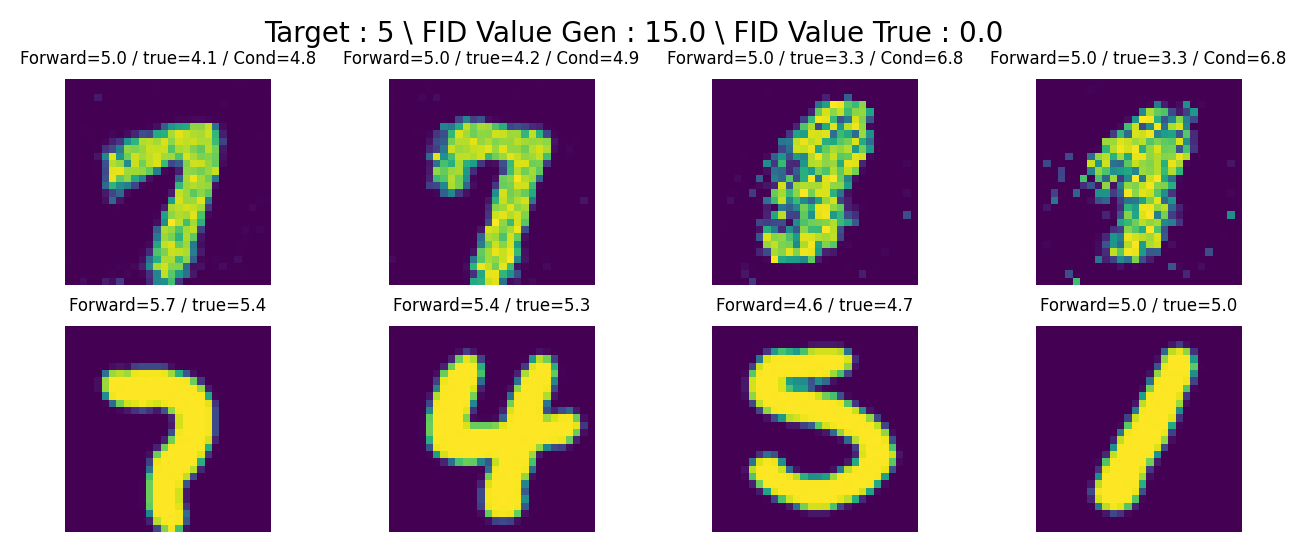

In [ ]:
inf_best_5, mean_sample_measure_5, fid_gen_5 = monte_carlo_inference(5, generator, forward, trainset, fulldataset, sample_number = 2000)





  0%|          | 0/2000 [00:00<?, ?img/s]



  0%|          | 1/2000 [00:27<15:04:09, 27.14s/img]



  5%|5         | 101/2000 [00:27<10:01:19, 19.00s/img]



  5%|5         | 101/2000 [00:47<10:01:19, 19.00s/img]



 20%|##        | 401/2000 [00:53<5:55:06, 13.32s/img] 



 25%|##5       | 501/2000 [00:55<3:53:09,  9.33s/img]



 25%|##5       | 501/2000 [01:07<3:53:09,  9.33s/img]



 40%|####      | 801/2000 [01:21<2:11:05,  6.56s/img]



 50%|#####     | 1001/2000 [01:22<1:16:28,  4.59s/img]



 50%|#####     | 1001/2000 [01:37<1:16:28,  4.59s/img]



 60%|######    | 1201/2000 [01:46<43:17,  3.25s/img]  



 65%|######5   | 1301/2000 [01:48<26:35,  2.28s/img]



 65%|######5   | 1301/2000 [02:07<26:35,  2.28s/img]



 80%|########  | 1601/2000 [02:13<10:47,  1.62s/img]



 85%|########5 | 1701/2000 [02:14<05:40,  1.14s/img]



100%|##########| 2000/2000 [02:15<00:00, 14.78img/s]




  0%|          | 0/4 [00:00<?, ?img/s]



100%|##########| 4/4 [00:00<00:00,  6.84img/s]



 ------------ Best forward image ------------
MSE measure pred = 0.11873836072583745
MSE morpho on Generated data: 1.6892546135902848
(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.9998033






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=16.3]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=15.6]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=15.7]



FID:  30%|███       | 3/10 [00:00<00:00, 25.37it/s, mean=15.7]



FID:  30%|███       | 3/10 [00:00<00:00, 25.37it/s, mean=15.5]



FID:  30%|███       | 3/10 [00:00<00:00, 25.37it/s, mean=15.8]



FID:  30%|███       | 3/10 [00:00<00:00, 25.37it/s, mean=15.7]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.39it/s, mean=15.7]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.39it/s, mean=15.7]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.39it/s, mean=15.7]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.39it/s, mean=15.7]



FID:  90%|█████████ | 9/10 [00:00<00:00, 26.07it/s, mean=15.7]



FID: 100%|██████████| 10/10 [00:00<00:00, 26.13it/s, mean=15.5]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.708]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.698]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.612]



FID:  30%|███       | 3/10 [00:00<00:00, 26.24it/s, mean=0.612]



FID:  30%|███       | 3/10 [00:00<00:00, 26.24it/s, mean=0.581]



FID:  30%|███       | 3/10 [00:00<00:00, 26.24it/s, mean=0.62] 



FID:  30%|███       | 3/10 [00:00<00:00, 26.24it/s, mean=0.579]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.17it/s, mean=0.579]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.17it/s, mean=0.558]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.17it/s, mean=0.551]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.17it/s, mean=0.534]



FID:  90%|█████████ | 9/10 [00:00<00:00, 25.73it/s, mean=0.534]



FID: 100%|██████████| 10/10 [00:00<00:00, 25.20it/s, mean=0.547]


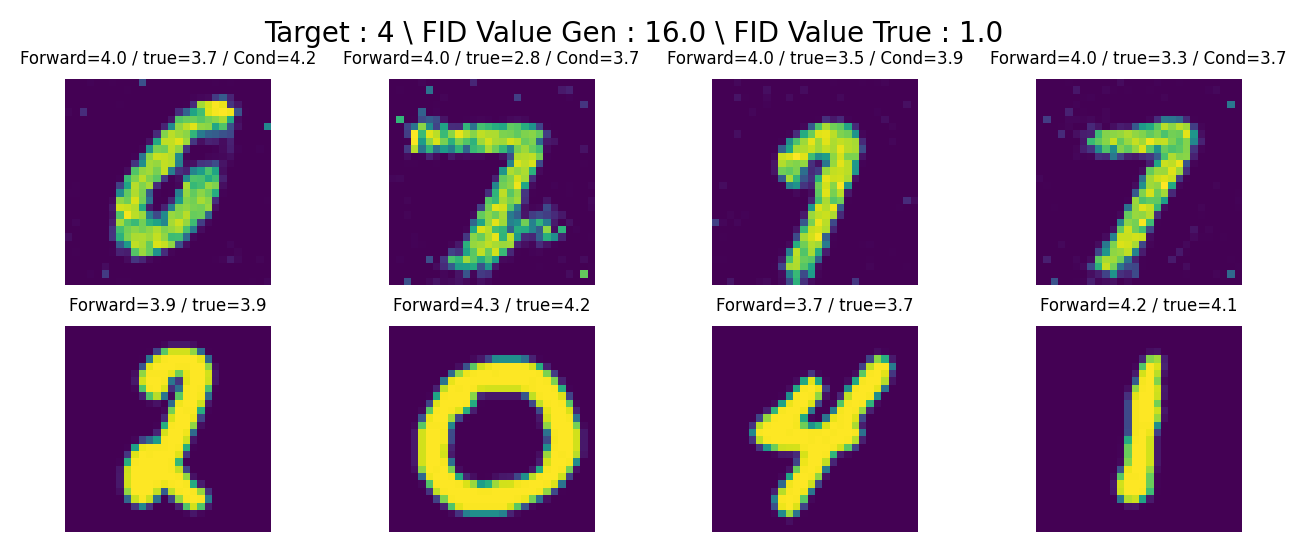

In [ ]:
inf_best_4, mean_sample_measure_4, fid_gen_4 = monte_carlo_inference(4, generator, forward, trainset, fulldataset, sample_number = 2000)





  0%|          | 0/2000 [00:00<?, ?img/s]



  0%|          | 1/2000 [00:26<14:27:23, 26.03s/img]



  5%|5         | 101/2000 [00:26<9:36:52, 18.23s/img]



 10%|#         | 201/2000 [00:27<6:22:34, 12.76s/img]



 15%|#5        | 301/2000 [00:27<4:12:55,  8.93s/img]



 15%|#5        | 301/2000 [00:43<4:12:55,  8.93s/img]



 20%|##        | 401/2000 [00:52<2:48:40,  6.33s/img]



 25%|##5       | 501/2000 [00:54<1:50:47,  4.43s/img]



 25%|##5       | 501/2000 [01:13<1:50:47,  4.43s/img]



 40%|####      | 801/2000 [01:19<1:02:32,  3.13s/img]



 45%|####5     | 901/2000 [01:21<40:14,  2.20s/img]  



 55%|#####5    | 1101/2000 [01:22<23:03,  1.54s/img]



 55%|#####5    | 1101/2000 [01:33<23:03,  1.54s/img]



 60%|######    | 1201/2000 [01:46<15:19,  1.15s/img]



 65%|######5   | 1301/2000 [01:48<09:25,  1.24img/s]



 70%|#######   | 1401/2000 [01:49<05:42,  1.75img/s]



 70%|#######   | 1401/2000 [02:03<05:42,  1.75img/s]



 80%|########  | 1601/2000 [02:13<02:53,  2.30


 ------------ Best forward image ------------
MSE measure pred = 0.5314444072975285
MSE morpho on Generated data: 1.5844161415944478


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.9973556






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=11.1]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=12]  



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=11.8]



FID:  30%|███       | 3/10 [00:00<00:00, 25.90it/s, mean=11.8]



FID:  30%|███       | 3/10 [00:00<00:00, 25.90it/s, mean=11.9]



FID:  30%|███       | 3/10 [00:00<00:00, 25.90it/s, mean=11.9]



FID:  30%|███       | 3/10 [00:00<00:00, 25.90it/s, mean=11.9]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.69it/s, mean=11.9]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.69it/s, mean=12]  



FID:  60%|██████    | 6/10 [00:00<00:00, 25.69it/s, mean=12]



FID:  60%|██████    | 6/10 [00:00<00:00, 25.69it/s, mean=12]



FID:  90%|█████████ | 9/10 [00:00<00:00, 26.19it/s, mean=12]



FID: 100%|██████████| 10/10 [00:00<00:00, 26.16it/s, mean=12]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.318]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.313]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.326]



FID:  30%|███       | 3/10 [00:00<00:00, 26.80it/s, mean=0.326]



FID:  30%|███       | 3/10 [00:00<00:00, 26.80it/s, mean=0.352]



FID:  30%|███       | 3/10 [00:00<00:00, 26.80it/s, mean=0.381]



FID:  30%|███       | 3/10 [00:00<00:00, 26.80it/s, mean=0.386]



FID:  60%|██████    | 6/10 [00:00<00:00, 26.57it/s, mean=0.386]



FID:  60%|██████    | 6/10 [00:00<00:00, 26.57it/s, mean=0.397]



FID:  60%|██████    | 6/10 [00:00<00:00, 26.57it/s, mean=0.406]



FID:  60%|██████    | 6/10 [00:00<00:00, 26.57it/s, mean=0.399]



FID:  90%|█████████ | 9/10 [00:00<00:00, 25.68it/s, mean=0.399]



FID: 100%|██████████| 10/10 [00:00<00:00, 25.20it/s, mean=0.401]


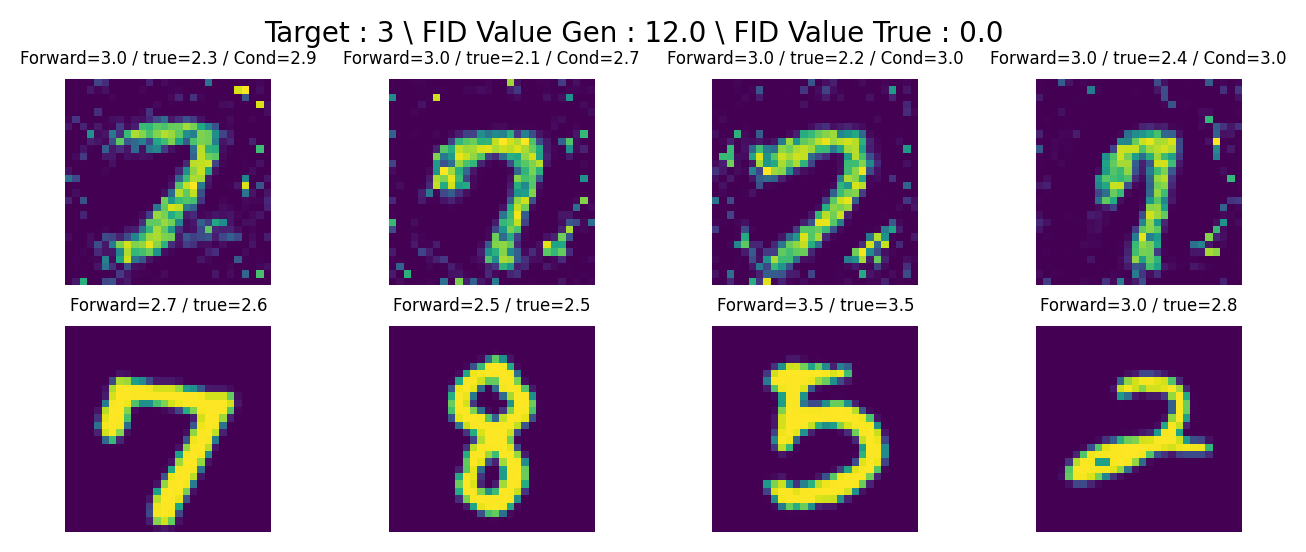

In [ ]:
inf_best_3, mean_sample_measure_3, fid_gen_3 = monte_carlo_inference(3, generator, forward, trainset, fulldataset, sample_number = 2000)





  0%|          | 0/2000 [00:00<?, ?img/s]



  0%|          | 1/2000 [00:27<15:24:18, 27.74s/img]



 15%|#5        | 301/2000 [00:28<9:09:56, 19.42s/img]



 15%|#5        | 301/2000 [00:38<9:09:56, 19.42s/img]



 20%|##        | 401/2000 [00:53<6:04:18, 13.67s/img]



 25%|##5       | 501/2000 [00:53<3:59:05,  9.57s/img]



 30%|###       | 601/2000 [00:53<2:36:12,  6.70s/img]



 30%|###       | 601/2000 [01:08<2:36:12,  6.70s/img]



 40%|####      | 801/2000 [01:19<1:34:29,  4.73s/img]



 45%|####5     | 901/2000 [01:21<1:00:42,  3.31s/img]



 45%|####5     | 901/2000 [01:38<1:00:42,  3.31s/img]



 60%|######    | 1201/2000 [01:46<31:13,  2.35s/img] 



 65%|######5   | 1301/2000 [01:48<19:10,  1.65s/img]



 75%|#######5  | 1501/2000 [01:48<09:34,  1.15s/img]



 75%|#######5  | 1501/2000 [01:58<09:34,  1.15s/img]



 80%|########  | 1601/2000 [02:14<05:53,  1.13img/s]



100%|##########| 2000/2000 [02:14<00:00, 14.83img/s]




  0%|          | 0/4 [00:00<?, ?img/s]



10


 ------------ Best forward image ------------
MSE measure pred = 0.5342715085765378
MSE morpho on Generated data: 0.7791826843293613


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.9992776






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=11.8]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=12]  



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=12.1]



FID:  30%|███       | 3/10 [00:00<00:00, 27.71it/s, mean=12.1]



FID:  30%|███       | 3/10 [00:00<00:00, 27.71it/s, mean=12.3]



FID:  30%|███       | 3/10 [00:00<00:00, 27.71it/s, mean=12.4]



FID:  30%|███       | 3/10 [00:00<00:00, 27.71it/s, mean=12.5]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.72it/s, mean=12.5]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.72it/s, mean=12.7]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.72it/s, mean=12.6]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.72it/s, mean=12.6]



FID:  90%|█████████ | 9/10 [00:00<00:00, 27.66it/s, mean=12.6]



FID: 100%|██████████| 10/10 [00:00<00:00, 27.43it/s, mean=12.6]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.637]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.542]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.538]



FID:  30%|███       | 3/10 [00:00<00:00, 28.34it/s, mean=0.538]



FID:  30%|███       | 3/10 [00:00<00:00, 28.34it/s, mean=0.541]



FID:  30%|███       | 3/10 [00:00<00:00, 28.34it/s, mean=0.518]



FID:  30%|███       | 3/10 [00:00<00:00, 28.34it/s, mean=0.5]  



FID:  60%|██████    | 6/10 [00:00<00:00, 27.87it/s, mean=0.5]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.87it/s, mean=0.471]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.87it/s, mean=0.452]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.87it/s, mean=0.442]



FID:  90%|█████████ | 9/10 [00:00<00:00, 26.94it/s, mean=0.442]



FID: 100%|██████████| 10/10 [00:00<00:00, 26.34it/s, mean=0.459]


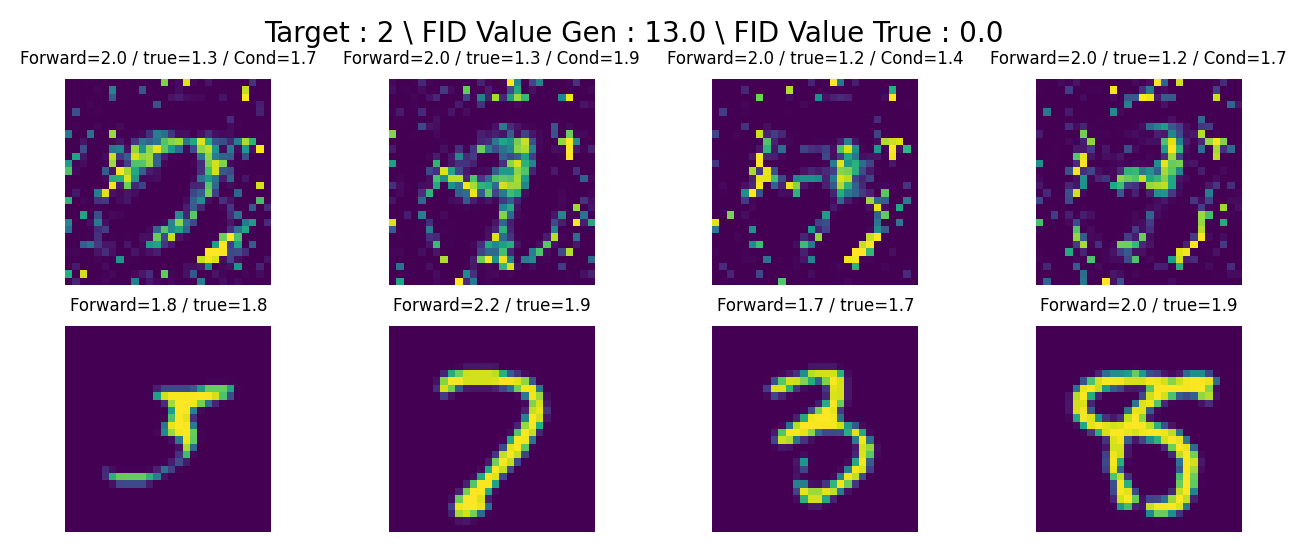

In [ ]:
inf_best_2, mean_sample_measure_2, fid_gen_2 = monte_carlo_inference(2, generator, forward, trainset, fulldataset, sample_number = 2000)





  0%|          | 0/2000 [00:00<?, ?img/s]



  0%|          | 1/2000 [00:27<15:17:53, 27.55s/img]



 10%|#         | 201/2000 [00:28<9:38:15, 19.29s/img]



 10%|#         | 201/2000 [00:45<9:38:15, 19.29s/img]



 20%|##        | 401/2000 [00:53<6:00:48, 13.54s/img]



 25%|##5       | 501/2000 [00:54<3:56:50,  9.48s/img]



 25%|##5       | 501/2000 [01:05<3:56:50,  9.48s/img]



 40%|####      | 801/2000 [01:23<2:13:10,  6.66s/img]



 40%|####      | 801/2000 [01:35<2:13:10,  6.66s/img]



 60%|######    | 1201/2000 [01:49<1:02:23,  4.69s/img]



 75%|#######5  | 1501/2000 [01:51<27:17,  3.28s/img]  



 75%|#######5  | 1501/2000 [02:05<27:17,  3.28s/img]



 80%|########  | 1601/2000 [02:14<15:43,  2.37s/img]



 85%|########5 | 1701/2000 [02:15<08:15,  1.66s/img]



100%|##########| 2000/2000 [02:16<00:00, 14.66img/s]




  0%|          | 0/4 [00:00<?, ?img/s]



100%|##########| 4/4 [00:00<00:00,  8.25img/s]



 ------------ Best forward image ------------
MSE measure pred = 0.012509240867493018
MSE morpho on Generated data: 0.15769173395058197
(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.99984014






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=24]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=23.9]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=23.7]



FID:  30%|███       | 3/10 [00:00<00:00, 28.39it/s, mean=23.7]



FID:  30%|███       | 3/10 [00:00<00:00, 28.39it/s, mean=23.7]



FID:  30%|███       | 3/10 [00:00<00:00, 28.39it/s, mean=23.8]



FID:  30%|███       | 3/10 [00:00<00:00, 28.39it/s, mean=23.9]



FID:  60%|██████    | 6/10 [00:00<00:00, 28.39it/s, mean=23.9]



FID:  60%|██████    | 6/10 [00:00<00:00, 28.39it/s, mean=23.8]



FID:  60%|██████    | 6/10 [00:00<00:00, 28.39it/s, mean=23.9]



FID:  60%|██████    | 6/10 [00:00<00:00, 28.39it/s, mean=23.9]



FID:  90%|█████████ | 9/10 [00:00<00:00, 28.27it/s, mean=23.9]



FID: 100%|██████████| 10/10 [00:00<00:00, 27.95it/s, mean=23.8]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.454]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.487]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.504]



FID:  30%|███       | 3/10 [00:00<00:00, 27.86it/s, mean=0.504]



FID:  30%|███       | 3/10 [00:00<00:00, 27.86it/s, mean=0.549]



FID:  30%|███       | 3/10 [00:00<00:00, 27.86it/s, mean=0.527]



FID:  30%|███       | 3/10 [00:00<00:00, 27.86it/s, mean=0.513]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.75it/s, mean=0.513]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.75it/s, mean=0.522]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.75it/s, mean=0.523]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.75it/s, mean=0.517]



FID:  90%|█████████ | 9/10 [00:00<00:00, 26.82it/s, mean=0.517]



FID: 100%|██████████| 10/10 [00:00<00:00, 26.02it/s, mean=0.532]


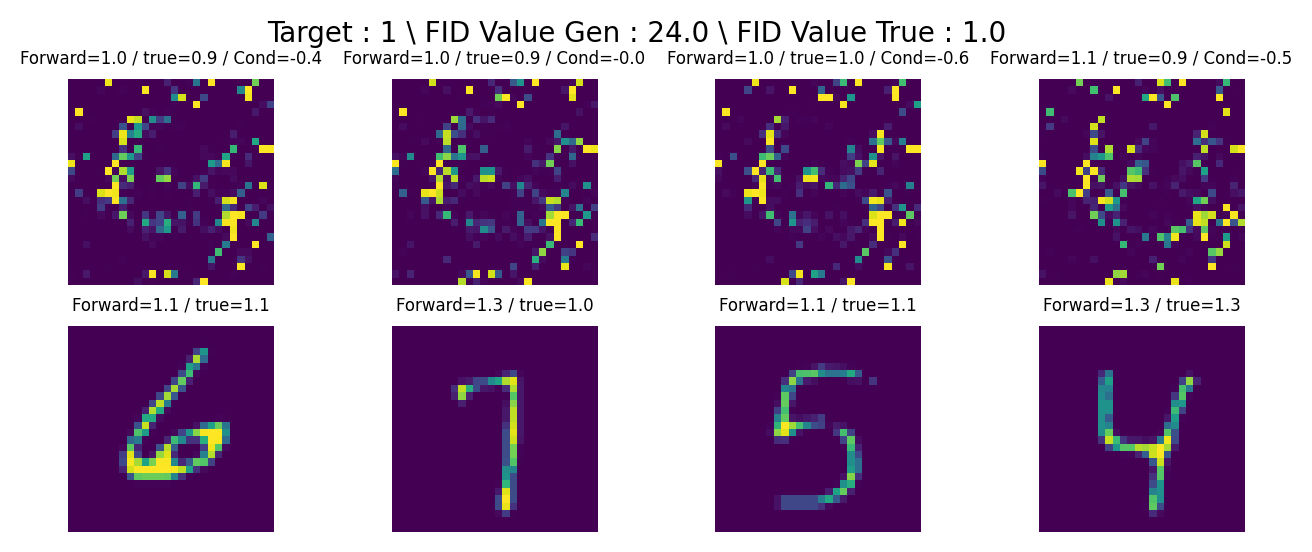

In [ ]:
inf_best_1, mean_sample_measure_1, fid_gen_1 = monte_carlo_inference(1, generator, forward, trainset, fulldataset, sample_number = 2000)

In [ ]:
generator = best_generator_out_distribution





  0%|          | 0/300 [00:00<?, ?img/s]



  0%|          | 1/300 [00:20<1:43:25, 20.75s/img]



100%|##########| 300/300 [00:21<00:00, 14.15img/s]




  0%|          | 0/4 [00:00<?, ?img/s]



100%|##########| 4/4 [00:00<00:00,  6.94img/s]


 ------------ Best forward image ------------
MSE measure pred = 13.619963691247278
MSE morpho on Generated data: 26.54438474779027


(300, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(300, 1, 32, 32) 0.0 0.99317086






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=36.5]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=35.5]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=34.9]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=34.6]



FID:  40%|████      | 4/10 [00:00<00:00, 30.84it/s, mean=34.6]



FID:  40%|████      | 4/10 [00:00<00:00, 30.84it/s, mean=34.8]



FID:  40%|████      | 4/10 [00:00<00:00, 30.84it/s, mean=35.3]



FID:  40%|████      | 4/10 [00:00<00:00, 30.84it/s, mean=35.8]



FID:  40%|████      | 4/10 [00:00<00:00, 30.84it/s, mean=36.7]



FID:  80%|████████  | 8/10 [00:00<00:00, 30.70it/s, mean=36.7]



FID:  80%|████████  | 8/10 [00:00<00:00, 30.70it/s, mean=36.7]



FID: 100%|██████████| 10/10 [00:00<00:00, 29.88it/s, mean=36.4]


(300, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(300, 1, 32, 32) 0.0 1.0






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=1.12]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=1.47]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=1.59]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=1.6] 



FID:  40%|████      | 4/10 [00:00<00:00, 30.93it/s, mean=1.6]



FID:  40%|████      | 4/10 [00:00<00:00, 30.93it/s, mean=1.54]



FID:  40%|████      | 4/10 [00:00<00:00, 30.93it/s, mean=1.51]



FID:  40%|████      | 4/10 [00:00<00:00, 30.93it/s, mean=1.48]



FID:  40%|████      | 4/10 [00:00<00:00, 30.93it/s, mean=1.49]



FID:  80%|████████  | 8/10 [00:00<00:00, 31.30it/s, mean=1.49]



FID:  80%|████████  | 8/10 [00:00<00:00, 31.30it/s, mean=1.45]



FID: 100%|██████████| 10/10 [00:00<00:00, 30.92it/s, mean=1.46]


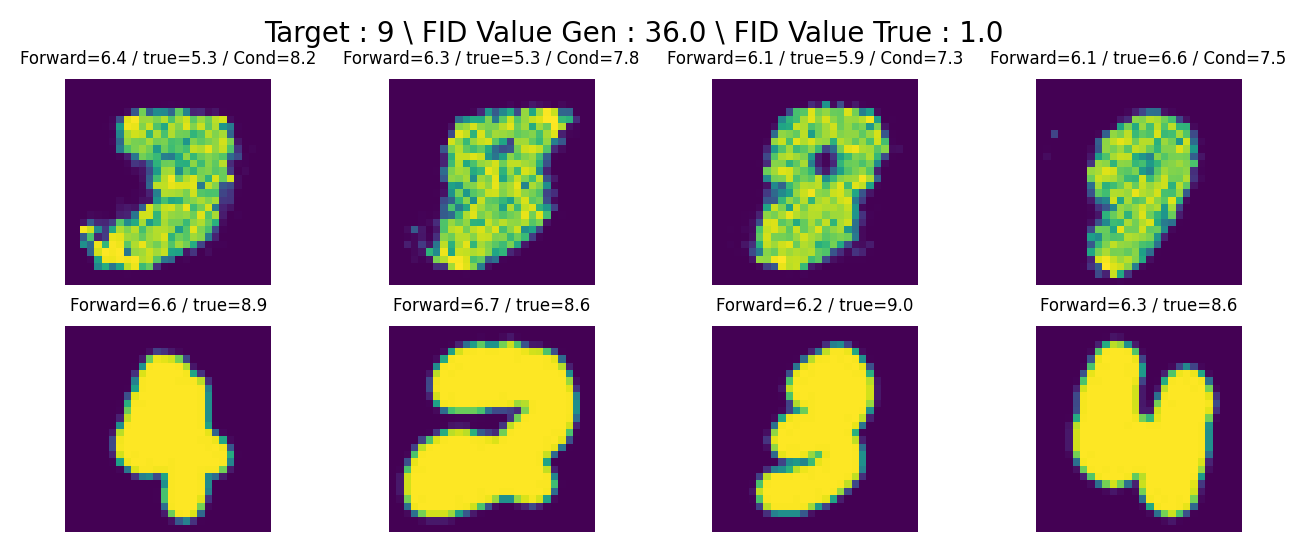

In [ ]:
inf_best_9, mean_sample_measure_9, fid_gen_9 = monte_carlo_inference(9, generator, forward, trainset, fulldataset, sample_number = 300)





  0%|          | 0/600 [00:00<?, ?img/s]



  0%|          | 1/600 [00:27<4:29:53, 27.03s/img]



 17%|#6        | 101/600 [00:27<2:37:24, 18.93s/img]



 67%|######6   | 401/600 [00:42<43:59, 13.26s/img]  



100%|##########| 600/600 [00:43<00:00, 13.92img/s]




  0%|          | 0/4 [00:00<?, ?img/s]



100%|##########| 4/4 [00:00<00:00,  8.11img/s]


 ------------ Best forward image ------------
MSE measure pred = 1.3861189853875784
MSE morpho on Generated data: 10.808783790734262


(600, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(600, 1, 32, 32) 0.0 0.992066






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=29.8]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=28.3]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=28.9]



FID:  30%|███       | 3/10 [00:00<00:00, 27.10it/s, mean=28.9]



FID:  30%|███       | 3/10 [00:00<00:00, 27.10it/s, mean=29.7]



FID:  30%|███       | 3/10 [00:00<00:00, 27.10it/s, mean=29.5]



FID:  30%|███       | 3/10 [00:00<00:00, 27.10it/s, mean=29.1]



FID:  60%|██████    | 6/10 [00:00<00:00, 26.55it/s, mean=29.1]



FID:  60%|██████    | 6/10 [00:00<00:00, 26.55it/s, mean=29.2]



FID:  60%|██████    | 6/10 [00:00<00:00, 26.55it/s, mean=29.4]



FID:  60%|██████    | 6/10 [00:00<00:00, 26.55it/s, mean=29.6]



FID:  90%|█████████ | 9/10 [00:00<00:00, 25.73it/s, mean=29.6]



FID: 100%|██████████| 10/10 [00:00<00:00, 25.11it/s, mean=29.7]


(600, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(600, 1, 32, 32) 0.0 1.0






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=1.08]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=1.04]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.985]



FID:  30%|███       | 3/10 [00:00<00:00, 28.49it/s, mean=0.985]



FID:  30%|███       | 3/10 [00:00<00:00, 28.49it/s, mean=0.973]



FID:  30%|███       | 3/10 [00:00<00:00, 28.49it/s, mean=0.95] 



FID:  30%|███       | 3/10 [00:00<00:00, 28.49it/s, mean=1.01]



FID:  60%|██████    | 6/10 [00:00<00:00, 28.42it/s, mean=1.01]



FID:  60%|██████    | 6/10 [00:00<00:00, 28.42it/s, mean=0.956]



FID:  60%|██████    | 6/10 [00:00<00:00, 28.42it/s, mean=0.96] 



FID:  60%|██████    | 6/10 [00:00<00:00, 28.42it/s, mean=0.933]



FID:  90%|█████████ | 9/10 [00:00<00:00, 28.42it/s, mean=0.933]



FID: 100%|██████████| 10/10 [00:00<00:00, 28.04it/s, mean=0.917]


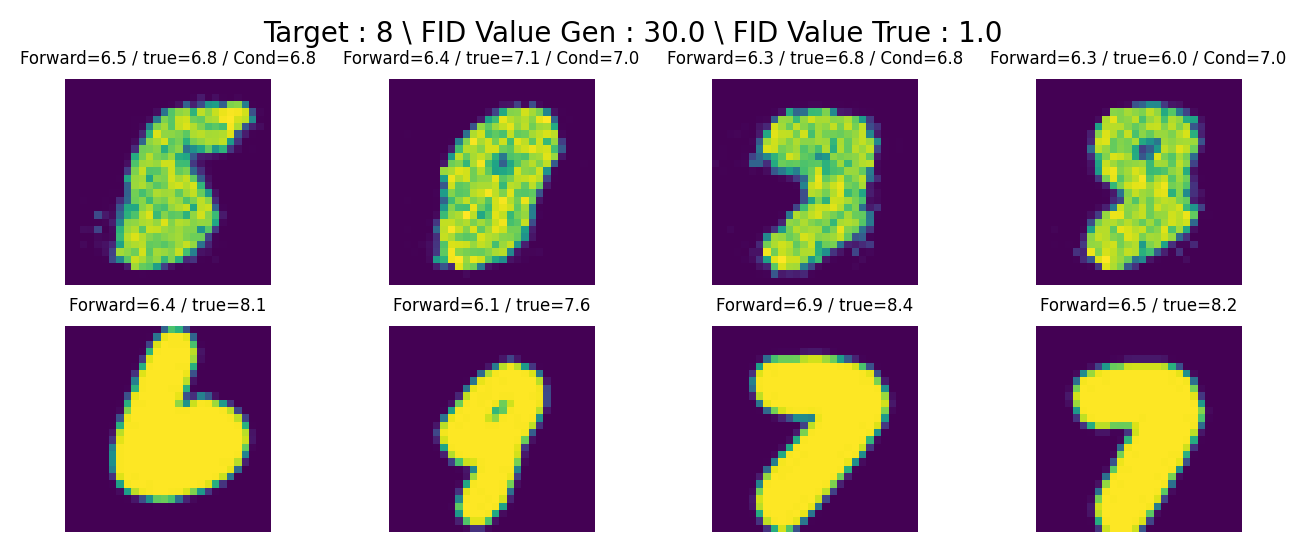

In [ ]:
inf_best_8, mean_sample_measure_8, fid_gen_8 = monte_carlo_inference(8, generator, forward, trainset, fulldataset, sample_number = 600)





  0%|          | 0/1000 [00:00<?, ?img/s]



  0%|          | 1/1000 [00:27<7:38:38, 27.55s/img]



 10%|#         | 101/1000 [00:28<4:48:56, 19.28s/img]



 30%|###       | 301/1000 [00:28<2:37:15, 13.50s/img]



 30%|###       | 301/1000 [00:45<2:37:15, 13.50s/img]



 40%|####      | 401/1000 [00:53<1:35:06,  9.53s/img]



 50%|#####     | 501/1000 [00:54<55:29,  6.67s/img]  



 70%|#######   | 701/1000 [00:55<23:16,  4.67s/img]



 80%|########  | 801/1000 [01:10<10:59,  3.31s/img]



100%|##########| 1000/1000 [01:10<00:00, 14.14img/s]




  0%|          | 0/4 [00:00<?, ?img/s]



100%|##########| 4/4 [00:00<00:00,  6.76img/s]


 ------------ Best forward image ------------
MSE measure pred = 0.20284082463952768
MSE morpho on Generated data: 3.783389111394672


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.0 0.9967613






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=22.4]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=23.7]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=24.1]



FID:  30%|███       | 3/10 [00:00<00:00, 27.91it/s, mean=24.1]



FID:  30%|███       | 3/10 [00:00<00:00, 27.91it/s, mean=24]  



FID:  30%|███       | 3/10 [00:00<00:00, 27.91it/s, mean=24.1]



FID:  30%|███       | 3/10 [00:00<00:00, 27.91it/s, mean=24]  



FID:  60%|██████    | 6/10 [00:00<00:00, 27.78it/s, mean=24]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.78it/s, mean=23.9]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.78it/s, mean=23.7]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.78it/s, mean=23.3]



FID:  90%|█████████ | 9/10 [00:00<00:00, 26.85it/s, mean=23.3]



FID: 100%|██████████| 10/10 [00:00<00:00, 26.42it/s, mean=23.3]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.0 1.0






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.598]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.544]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.576]



FID:  30%|███       | 3/10 [00:00<00:00, 28.14it/s, mean=0.576]



FID:  30%|███       | 3/10 [00:00<00:00, 28.14it/s, mean=0.628]



FID:  30%|███       | 3/10 [00:00<00:00, 28.14it/s, mean=0.665]



FID:  30%|███       | 3/10 [00:00<00:00, 28.14it/s, mean=0.67] 



FID:  60%|██████    | 6/10 [00:00<00:00, 27.93it/s, mean=0.67]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.93it/s, mean=0.687]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.93it/s, mean=0.682]



FID:  60%|██████    | 6/10 [00:00<00:00, 27.93it/s, mean=0.672]



FID:  90%|█████████ | 9/10 [00:00<00:00, 27.68it/s, mean=0.672]



FID: 100%|██████████| 10/10 [00:00<00:00, 27.34it/s, mean=0.693]


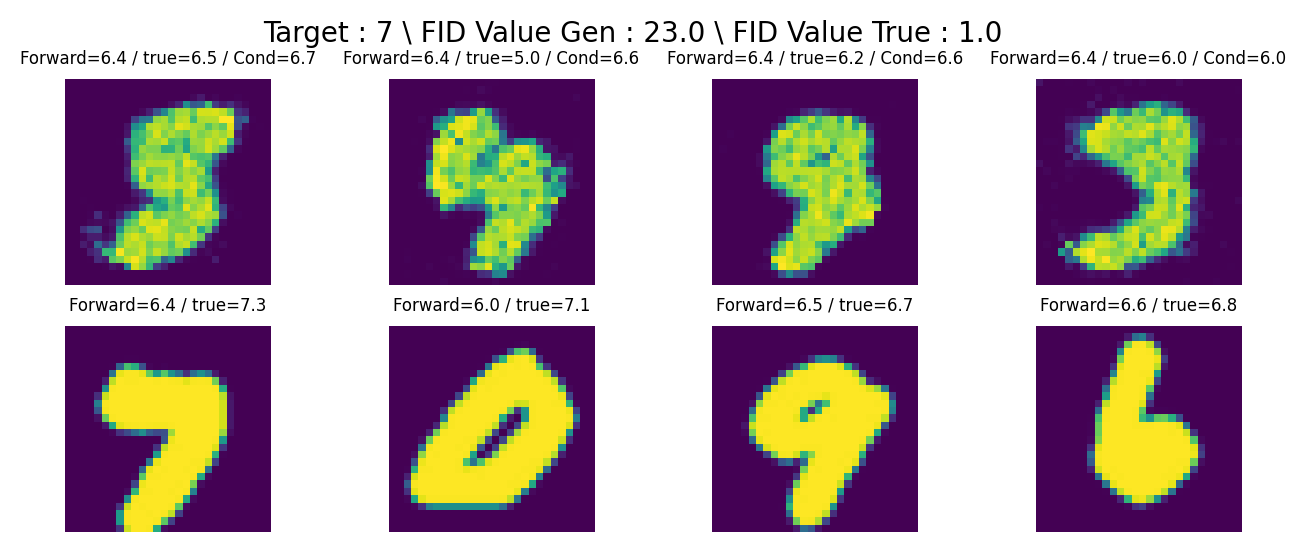

In [ ]:
inf_best_7, mean_sample_measure_7, fid_gen_7 = monte_carlo_inference(7, generator, forward, trainset, fulldataset, sample_number = 1000)





  0%|          | 0/2000 [00:00<?, ?img/s]



  0%|          | 1/2000 [00:26<14:55:01, 26.86s/img]



  5%|5         | 101/2000 [00:27<9:55:11, 18.81s/img]



 10%|#         | 201/2000 [00:28<6:34:49, 13.17s/img]



 10%|#         | 201/2000 [00:42<6:34:49, 13.17s/img]



 20%|##        | 401/2000 [00:53<4:06:39,  9.26s/img]



 25%|##5       | 501/2000 [00:55<2:41:58,  6.48s/img]



 35%|###5      | 701/2000 [00:55<1:38:16,  4.54s/img]



 35%|###5      | 701/2000 [01:12<1:38:16,  4.54s/img]



 40%|####      | 801/2000 [01:21<1:05:00,  3.25s/img]



 50%|#####     | 1001/2000 [01:22<37:56,  2.28s/img] 



 50%|#####     | 1001/2000 [01:32<37:56,  2.28s/img]



 60%|######    | 1201/2000 [01:47<21:44,  1.63s/img]



 65%|######5   | 1301/2000 [01:48<13:22,  1.15s/img]



 75%|#######5  | 1501/2000 [01:49<06:41,  1.24img/s]



 75%|#######5  | 1501/2000 [02:02<06:41,  1.24img/s]



 80%|########  | 1601/2000 [02:13<04:14,  1.57img/s]



 85%|########5 | 1701/2000 [02:14<02:14,  2.23


 ------------ Best forward image ------------
MSE measure pred = 0.44729397138058935
MSE morpho on Generated data: 1.4415056940807442


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.9979495






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=18.5]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=19.3]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=19.4]



FID:  30%|███       | 3/10 [00:00<00:00, 24.25it/s, mean=19.4]



FID:  30%|███       | 3/10 [00:00<00:00, 24.25it/s, mean=19.5]



FID:  30%|███       | 3/10 [00:00<00:00, 24.25it/s, mean=19.5]



FID:  30%|███       | 3/10 [00:00<00:00, 24.25it/s, mean=19.3]



FID:  60%|██████    | 6/10 [00:00<00:00, 24.69it/s, mean=19.3]



FID:  60%|██████    | 6/10 [00:00<00:00, 24.69it/s, mean=19.2]



FID:  60%|██████    | 6/10 [00:00<00:00, 24.69it/s, mean=19.3]



FID:  60%|██████    | 6/10 [00:00<00:00, 24.69it/s, mean=19.2]



FID:  90%|█████████ | 9/10 [00:00<00:00, 24.76it/s, mean=19.2]



FID: 100%|██████████| 10/10 [00:00<00:00, 25.11it/s, mean=19.2]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0






FID:   0%|          | 0/10 [00:00<?, ?it/s]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.282]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.309]



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=0.302]



FID:  30%|███       | 3/10 [00:00<00:00, 29.56it/s, mean=0.302]



FID:  30%|███       | 3/10 [00:00<00:00, 29.56it/s, mean=0.333]



FID:  30%|███       | 3/10 [00:00<00:00, 29.56it/s, mean=0.317]



FID:  30%|███       | 3/10 [00:00<00:00, 29.56it/s, mean=0.339]



FID:  60%|██████    | 6/10 [00:00<00:00, 29.05it/s, mean=0.339]



FID:  60%|██████    | 6/10 [00:00<00:00, 29.05it/s, mean=0.347]



FID:  60%|██████    | 6/10 [00:00<00:00, 29.05it/s, mean=0.344]



FID:  60%|██████    | 6/10 [00:00<00:00, 29.05it/s, mean=0.337]



FID:  90%|█████████ | 9/10 [00:00<00:00, 27.90it/s, mean=0.337]



FID: 100%|██████████| 10/10 [00:00<00:00, 26.76it/s, mean=0.336]


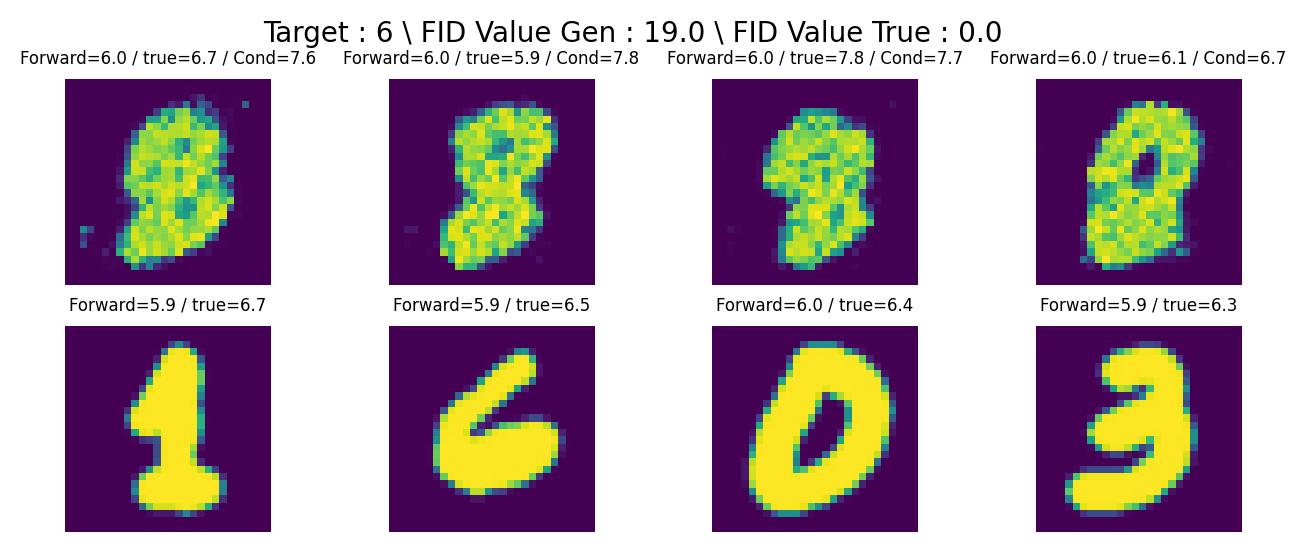

In [ ]:
inf_best_6, mean_sample_measure_6, fid_gen_6 = monte_carlo_inference(6, generator, forward, trainset, fulldataset, sample_number = 2000)

In [ ]:
monte_carlo_inference(5, generator, forward, trainset, testset, sample_number = 2000)

In [ ]:
monte_carlo_inference(4, generator, forward, trainset, testset, sample_number = 2000)

In [ ]:
monte_carlo_inference(3, generator, forward, trainset, testset, sample_number = 2000)

In [ ]:
monte_carlo_inference(2, generator, forward, trainset, testset, sample_number = 2000)

In [ ]:
monte_carlo_inference(1, generator, forward, trainset, testset, sample_number = 2000)

In [ ]:
# Print results
in_distribution_wo_inf = (mean_sample_measure_5 + mean_sample_measure_4 + mean_sample_measure_3 + mean_sample_measure_2)/4 #+ mean_sample_measure_1)/5
in_distribution_full_model = (inf_best_5 + inf_best_4 + inf_best_3 + inf_best_2)/4 #+ inf_best_1)/5
out_distribution_wo_inf = (mean_sample_measure_9 + mean_sample_measure_8 + mean_sample_measure_7 + mean_sample_measure_6)/4 
out_distribution_full_model = (inf_best_9 + inf_best_8 + inf_best_7 + inf_best_6)/4 
fid_in_distribution = (fid_gen_5 + fid_gen_4 + fid_gen_3 + fid_gen_2)/4 #+ fid_gen_1)/5
fid_out_distribution = (fid_gen_9 + fid_gen_8 + fid_gen_7 + fid_gen_6)/4 
print(f' ------------------ full model \ model w/o inference ------------------ ')
print(f' ACC in = {in_distribution_full_model}   /   ACC in = {in_distribution_wo_inf} ')
print(f' ACC out = {out_distribution_full_model}   /   ACC out = {out_distribution_wo_inf} ')
print(f' FID in = {fid_in_distribution}\n FID out = {fid_out_distribution}')

 ------------------ full model \ model w/o inference ------------------ 
 ACC in = 0.5206389089819201   /   ACC in = 1.3167660595611563 
 ACC out = 3.9140543681637436   /   ACC out = 10.644515835999988 
 FID in = 13.8894153290104
 FID out = 27.158968297186625
